**EXAM MARS 2023**



**EXERCICE 1 - SHIFT TABLE ELEMENTS**


Inspired by exercice 2 during course,  
the goal of this exercice is to shift all values of a 4x4 array to the right or to the left (depending of a parameter). With "a" as the input array and "b" as the output array, in case of right shift first value of "a" corresponds to second value of "b", second value of "a" corresponds to third value of "b" etc...   
Exception: first value of "b" corresponds to last value of "a". And the opposite when left shift.  

Expected result for right shift:
 
######## a #########  
[[59 85  1 40]  
[11 57 36 34]  
[22 91 98  5]  
[79 61 71 26]]    
######## b #########  
[[26 59 85  1]  
[40 11 57 36]  
[34 22 91 98]  
[ 5 79 61 71]]  

Expected result for left shift:
 
######## a #########  
[[20 50  9 12]  
 [54 16  8 65]  
 [98 23  2 77]  
 [60 36 87 28]]  
######## b #########  
[[50  9 12 54]  
 [16  8 65 98]  
 [23  2 77 60]  
 [36 87 28 20]]  
 
 Tips: use numpy.int32(1) for right shift and numpy.int32(0) for left shift 

> INSTALL

In [1]:
!pip install pycuda==2020.1
!pip install appdirs==1.4.0

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


> LIBRARIES

In [2]:
import numpy

import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule

> CUDA KERNEL

In [3]:
mod = SourceModule("""
__global__ void shiftme(const int * a, int * b, int rightshift, int dim0, int dim1)
  {
    //### WRITE CODE HERE ###
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    printf("idx %d",idx);
    if(rightshift){
       if(idx < dim0*dim1-1){
          b[idx+1] = a[idx];
       }else if(idx == dim0*dim1-1){
          b[0] = a[idx];
       }
    }else{
       if(idx != 0){
         b[idx-1] = a[idx];
       }else if(idx ==0){
         b[dim0*dim1-1] = a[0];
       }
      
    }
    
    if(rightshift){
      if(idx < dim0*dim1){printf("idx %d, threadIdx.x %d, a[idx] %d b[idx+1] %d \\n", threadIdx.x, idx, a[idx], b[idx+1]);}
    }else{
      if(idx != 0){printf("idx %d, threadIdx.x %d, a[idx] %d b[idx-1] %d \\n", threadIdx.x, idx, a[idx], b[idx-1]);}
    }
  }
""")

> PYTHON CODE

In [4]:
print("############ ",drv.Device(0).name(), "############")

# create 4x4 array of random integers from 1 to 99
a = numpy.random.randint(low=1, high=100, size=(4,4))
a = a.astype(numpy.int32)

print(a.shape, a.dtype, a.nbytes, int(a.size))

### WRITE CODE HERE ###
a_gpu = drv.mem_alloc(a.nbytes)
drv.memcpy_htod(a_gpu, a)
b = numpy.empty_like(a)
b = b.astype(numpy.int32)
b_gpu = drv.mem_alloc(b.nbytes)
drv.memcpy_htod(b_gpu, b)

dorightshift = 1
shiftit = mod.get_function("shiftme")
print(a.shape[0],a.shape[1] )
shiftit(a_gpu, b_gpu, numpy.int32(dorightshift), numpy.int32(a.shape[0]),numpy.int32(a.shape[1]), block=(16,1,1))

drv.memcpy_dtoh(b, b_gpu)


print("######## a #########")
print (a)
print("######## b #########")
print (b)

############  NVIDIA Tesla K80 ############
(4, 4) int32 64 16
4 4
######## a #########
[[93 37 60 84]
 [79 19 10 93]
 [37 79 38 43]
 [96 49 10 63]]
######## b #########
[[63 93 37 60]
 [84 79 19 10]
 [93 37 79 38]
 [43 96 49 10]]
idx 0idx 1idx 2idx 3idx 4idx 5idx 6idx 7idx 8idx 9idx 10idx 11idx 12idx 13idx 14idx 15idx 0, threadIdx.x 0, a[idx] 93 b[idx+1] 93 
idx 1, threadIdx.x 1, a[idx] 37 b[idx+1] 37 
idx 2, threadIdx.x 2, a[idx] 60 b[idx+1] 60 
idx 3, threadIdx.x 3, a[idx] 84 b[idx+1] 84 
idx 4, threadIdx.x 4, a[idx] 79 b[idx+1] 79 
idx 5, threadIdx.x 5, a[idx] 19 b[idx+1] 19 
idx 6, threadIdx.x 6, a[idx] 10 b[idx+1] 10 
idx 7, threadIdx.x 7, a[idx] 93 b[idx+1] 93 
idx 8, threadIdx.x 8, a[idx] 37 b[idx+1] 37 
idx 9, threadIdx.x 9, a[idx] 79 b[idx+1] 79 
idx 10, threadIdx.x 10, a[idx] 38 b[idx+1] 38 
idx 11, threadIdx.x 11, a[idx] 43 b[idx+1] 43 
idx 12, threadIdx.x 12, a[idx] 96 b[idx+1] 96 
idx 13, threadIdx.x 13, a[idx] 49 b[idx+1] 49 
idx 14, threadIdx.x 14, a[idx] 10 b[idx+1] 10

**EXERCICE 2 - PIXELATE**


Read a grayscale image, then using GPU, create another image that is pixelated

![alt text](images/exam/exam.png "Exam")

> INSTALL

In [5]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


> LIBRARIES

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import pycuda.autoinit
import pycuda.driver as drv
import pycuda.gpuarray as gpuarray
import numpy
import math

import argparse

from pycuda.compiler import SourceModule


> CUDA KERNEL

In [7]:
mod = SourceModule("""
__global__ void applyPixelization(int *dest, int *source, int width, int height, int pixelsize)
{
    //### WRITE CODE HERE ###
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    int idy = threadIdx.y + blockIdx.y * blockDim.y;

        int sum =0;
        for(int i=0;i<pixelsize;i++){
            for(int j=0; j<pixelsize;j++){
                //avoid counting pixel twice: on a 2D plane projected to a 1D plane, need to get adjacent pixel in 2D but not "leak out" of the width boarder (if mod(width/pixelsize) != 0) 
                if((idx*pixelsize+i)  < width*(idy*pixelsize+1+i) && (idx*pixelsize+i) + (idy*pixelsize+j)*width < height*width){//do not exceed the total number of pixel (width*height)
                    sum = sum+source[(idx*pixelsize+i) + (idy*pixelsize+j)*width]; 
                }
            }
        }
        
        //fill pixel values with mean (pixelsize x pixelsize grid)
        for(int i=0;i<pixelsize;i++){
            for(int j=0; j<pixelsize;j++){
                if((idx*pixelsize+i)  < width*(idy*pixelsize+1+i) && (idx*pixelsize+i) + (idy*pixelsize+j)*width < height*width){ 
                    dest[(idx*pixelsize+i) + (idy*pixelsize+j)*width] = sum/(pixelsize*pixelsize);
      
                }
            }
         }
        
      //  if((idx*pixelsize)  < width*(idy*pixelsize+1+i)  && (idx*pixelsize) + (idy*pixelsize)*width < height*width){ 
       //     printf("idx %d, idy %d, pixelid %d,  dest %d \\n",idx,idy,(idx*pixelsize) + idy*pixelsize*width , dest[(idx*pixelsize) + idy*pixelsize*width]);
      //  }
        

    
}
""")


> PYTHON CODE

(500, 500)
250000


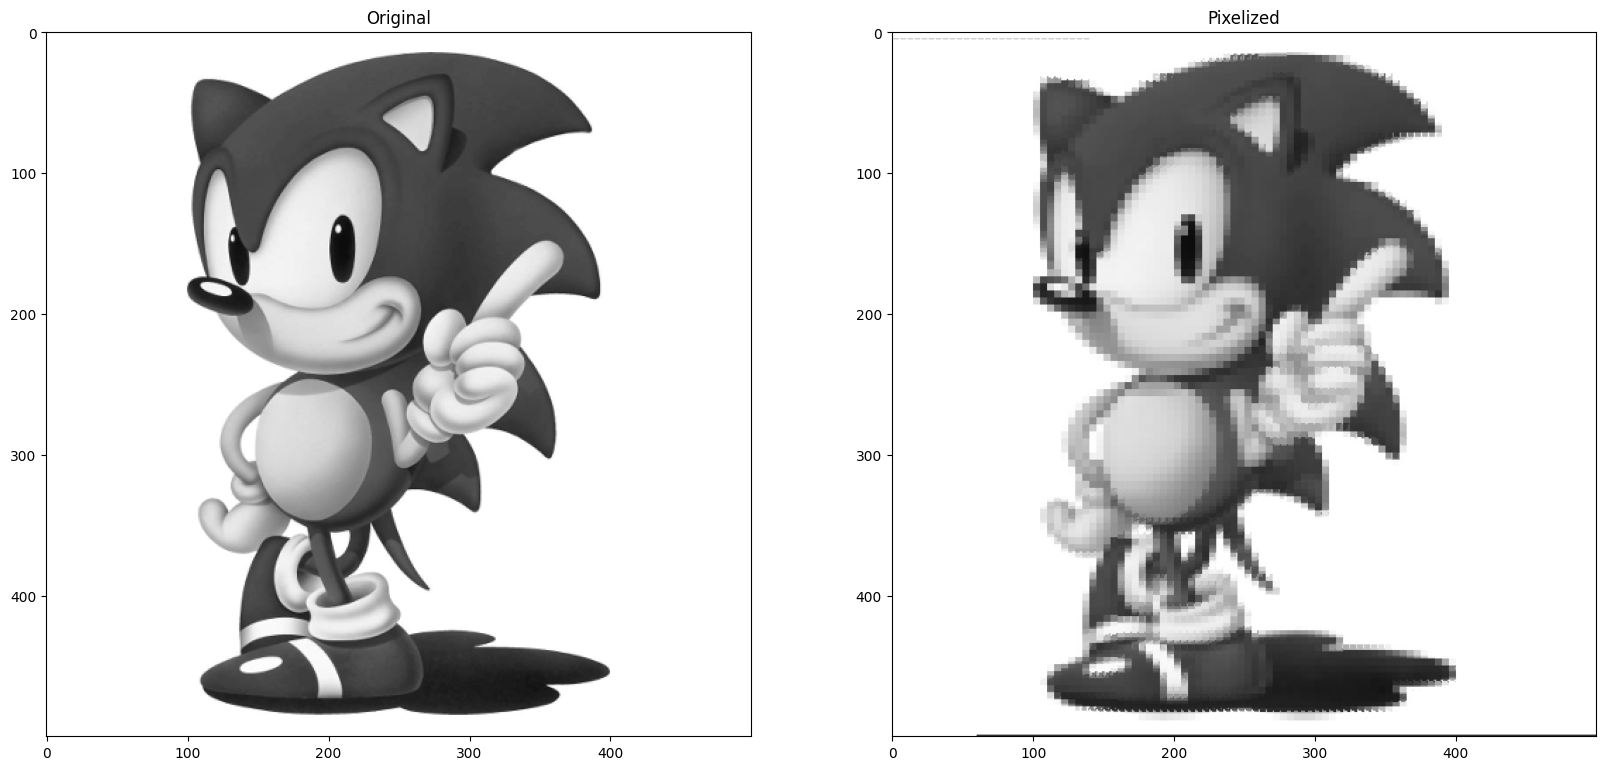

In [9]:
# read image
img_path = "images/exam/sonic.png"
# pixelsize = size of pixel zone from current pixel (top left) to compute new pixels (set to mean of all pixels in zone) (example here with pixelsize = 5)
#  0 x x x x
#  x x x x x
#  x x x x x
#  x x x x x 
#  x x x x x 

pixelsize = 5

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = img.astype(numpy.int32)

### WRITE CODE HERE 
#input
print(img.shape)
print(img.size)
width, height = img.shape
img_gpu = drv.mem_alloc(img.nbytes)
drv.memcpy_htod(img_gpu, img)

#output
pixelized = np.empty_like(img)
pixelized = pixelized.astype(np.int32)
pixelized_gpu = drv.mem_alloc(pixelized.nbytes)
drv.memcpy_htod(pixelized_gpu, pixelized)

#to define dimensions of GPU needed
BLOCK_SIZE = 1024

#get function
pixelit = mod.get_function("applyPixelization")
pixelit(pixelized_gpu,img_gpu,
        np.int32(width),np.int32(height),
        np.int32(pixelsize),
        block = (int(np.sqrt(BLOCK_SIZE)), int(np.sqrt(BLOCK_SIZE)), 1),
        grid  = (math.ceil(width / np.sqrt(BLOCK_SIZE)), math.ceil(height / np.sqrt(BLOCK_SIZE)),1)
    
)

drv.memcpy_dtoh(pixelized, pixelized_gpu)
pixelized = pixelized.astype(np.int32)

#Show Images
plt.rcParams['figure.figsize'] = [20, 10]
fig, (ax0,ax1) = plt.subplots(1, 2)

# Show Original
ax0.set_title("Original")
ax0.imshow(img, cmap=plt.get_cmap('gray'), vmin = 0, vmax = 255)

# Show Pixelate
ax1.set_title("Pixelized")
ax1.imshow(pixelized, cmap=plt.get_cmap('gray'), vmin = 0, vmax = 255)

fig.show()
